# Data Analyst Nanodegree

## Project 2:  Investigate a Dataset
## Titanic Data - Who Survived the Sinking of the Titanic and Why?

In this project, we will explore and investigate the dataset related to the survival of passengers on the RMS Titanic as it sank on the morning of April 15, 1912.

## Loading the Data

We will use a DataFrame from the pandas library to load the comma separated value (csv) file associated with the Titanic survival data.

In [29]:
# important imports

import pandas as pd
import numpy as np

# display
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plotting and visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [30]:
# Load the data
titanic_df = pd.read_csv('titanic-data.csv')

display(titanic_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
titanic_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Begin Exploration

From the kaggle website, we have the definitions of each of the variables:

**VARIABLE DESCRIPTIONS**:
- survival: Survival (0 = No; 1 = Yes)
- pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name: Name
- sex: Sex
- age: Age
- sibsp: Number of Siblings/Spouses Aboard
- parch: Number of Parents/Children Aboard
- ticket: Ticket Number
- fare: Passenger Fare
- cabin: Cabin
- embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

(For whatever reason these don't line up exactly with the names of our column headers, but we get the idea.)

### Questions 

What do we expect to determine the survival of passengers on the Titanic? We might start by predicting that women and children are more likely to have survived than men because of the traditional policy of getting women and children to safety first. This yields the following questions:

- How does gender affect passenger survival? (variable Sex)
- How does age affect passenger survival? (variable Age)


We might also cynically guess that more 1st class passengers would have been more likely to survive because they were able to take advantage of their wealth to curry special favor. It's not clear that this would be the case in such a drastic crisis situation and it is also not immediately obvious to me that first class passenger quarters would have been better positioned for escape. This might be an interesting question to resolve.

- How does socioeconomic class affect passenger survival? (variables Pclass and Fare)

This gives us one dependent variable (Survived) and four independent variables (Sex, Age, Pclass, Fare).



## Cleaning the Data

In [32]:
# Remove the columns with data we have decided is irrelevant. 
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Cabin']
del titanic_df['Embarked']
del titanic_df['SibSp']
del titanic_df['Parch']

display(titanic_df.head())

,PassengerId,Survived,Pclass,Sex,Age,Fare
0,1,0,3,male,22.0,7.2500
1,2,1,1,female,38.0,71.2833
2,3,1,3,female,26.0,7.9250
3,4,1,1,female,35.0,53.1000
4,5,0,3,male,35.0,8.0500


In [33]:
titanic_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
Fare           float64
dtype: object

##  How did gender affect the survival of the passengers?

I'm interested in what percentage of women survived compared to what percentage of men survived. It turns out this is not particularly difficult to do, we just divide the number of females who survived by the total number of females and divide the number of males who survived by the total number of males and compare those two numbers.

In [34]:
print '\nPercent Survived\n', titanic_df.groupby('Sex')['Survived'].sum() / titanic_df['Sex'].value_counts()


Percent Survived
female    0.742038
male      0.188908
dtype: float64


This supports our hypothesis that women were more likely to survive. Almost 75% of the females survived whereas not even 20% of the males survived. It helps to take these numbers in the context of the actual numbers of male and femal passengers:

In [35]:
total = titanic_df['Sex'].value_counts()
survivors = titanic_df.groupby('Sex')['Survived'].sum()
casualties = total - survivors

In [36]:
print 'Total Passengers\n', total
print '\nSurvivors\n', survivors
print '\nCasualties\n', casualties

Total Passengers
male      577
female    314
Name: Sex, dtype: int64

Survivors
Sex
female    233
male      109
Name: Survived, dtype: int64

Casualties
female     81
male      468
dtype: int64


In [37]:
# Rows in total need to be swapped
total.sort_values(inplace=True)
print total

female    314
male      577
Name: Sex, dtype: int64


### Visualizations

Here is a bar graph showing total passengers (yellow) and survivors (blue) of each gender.

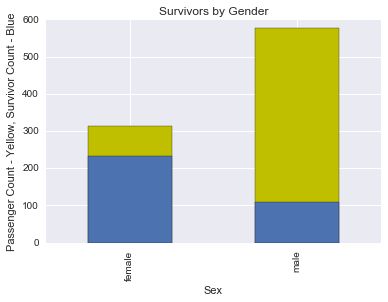

In [38]:
total.plot(kind='bar', color='y', title = 'Survivors by Gender').set_ylabel('Passenger Count - Yellow, Survivor Count - Blue')
survivors.plot(kind='bar')

Here is a boxplot demonstrating the logarithmically adjusted fare for each gender. The women are interestingly more likely to have paid more for their tickets.

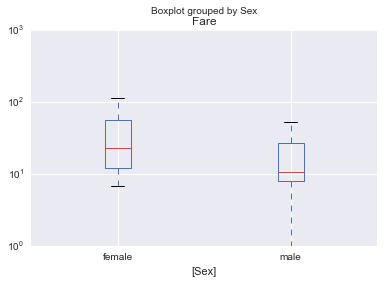

In [39]:
titanic_df.boxplot(column = ['Fare'], by = ['Sex']).set_yscale('log')

## How did age affect the survival of the passengers?

Our hypothesis is that efforts would have been made to save women and children first and thus passengers falling into younger age groups would be more likely to survive. In order to determine this it will be helpful to create age group categories and determine into which one each passenger falls. Let's use the following:

- Infant: 1 year old or less
- Toddler: 2 or 3 years old
- Child: 4 to 12 years old
- Adolescent: 13 to 18 years old
- Adult: 19 to 60 years old
- Senior: Above 60 years old

In [40]:
def age_group(age):
    if age <= 0.0:
        # After looking through the data we see that this case will not actually occur in our dataset
        return 'Error: Age Less Than Zero'
    elif age <= 1.0:
        return '1. Infant (0-1)'
    elif age <= 3.0:
        return '2. Toddler (2-3)'
    elif age <= 12.0:
        return '3. Child (4-12)'
    elif age <= 18.0:
        return '4. Adolescent (13-18)'
    elif age <= 60.0:
        return '5. Adult (19-60)'
    elif age > 60.0:
        return '6. Senior (>60)'
    else:
        # After looking through the data we see that this case will only occur on NaN entries
        return 'No Age Reported'

# Add a new column for the age group of the passenger
titanic_df['AgeGroup'] = titanic_df['Age'].apply(age_group) 

display(titanic_df.head())

,PassengerId,Survived,Pclass,Sex,Age,Fare,AgeGroup
0,1,0,3,male,22.0,7.2500,5. Adult (19-60)
1,2,1,1,female,38.0,71.2833,5. Adult (19-60)
2,3,1,3,female,26.0,7.9250,5. Adult (19-60)
3,4,1,1,female,35.0,53.1000,5. Adult (19-60)
4,5,0,3,male,35.0,8.0500,5. Adult (19-60)


### What is the likelihood of survival for each age group?

In [41]:
# Taking the mean here effectively reveals the likelihood of survival for members of each age group.
likelihood_ag = titanic_df.groupby('AgeGroup')['Survived'].mean()
print likelihood_ag

AgeGroup
1. Infant (0-1)          0.857143
2. Toddler (2-3)         0.500000
3. Child (4-12)          0.512821
4. Adolescent (13-18)    0.428571
5. Adult (19-60)         0.388788
6. Senior (>60)          0.227273
No Age Reported          0.293785
Name: Survived, dtype: float64


We can see above that members of younger age groups are more likely to survive. Seniors were the least likely to survive. This supports our hypothesis that younger passengers, particularly children, toddlers and infants would be given priority over seniors, adults and adolescents.

Interestingly, those for whom the age is not known were even less likely to survive than adults. This could be explained by the possibility that their information may have been harder to find since they were dead. It might also be that it may have been harder to find information on exact age from members of the lower economic class. This would be an interesting avenue for inquiry.

Of course, it's important to take these results in the context of the actual numbers of people from each age group present.

In [42]:
count_ag = titanic_df['AgeGroup'].value_counts()
print count_ag

5. Adult (19-60)         553
No Age Reported          177
4. Adolescent (13-18)     70
3. Child (4-12)           39
6. Senior (>60)           22
2. Toddler (2-3)          16
1. Infant (0-1)           14
Name: AgeGroup, dtype: int64


In [43]:
#The count_ag series needs to be re-ordered and properly sorted in order to show up properly in a bar graph
count_ag.sort_index(inplace=True)
print count_ag

1. Infant (0-1)           14
2. Toddler (2-3)          16
3. Child (4-12)           39
4. Adolescent (13-18)     70
5. Adult (19-60)         553
6. Senior (>60)           22
No Age Reported          177
Name: AgeGroup, dtype: int64


Notice that adults make up the overwhelming majority of passengers and those with no information available regarding there age are also well represented.

### Visualizations

Here is a bar graph showing total passengers (yellow) and survivors (blue) in each age group.

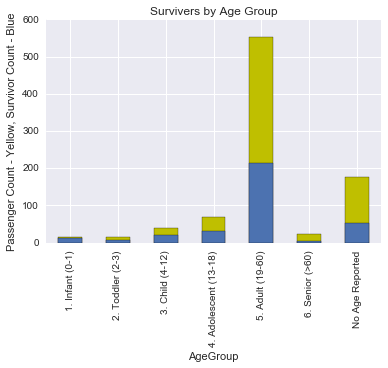

In [44]:
count_ag.plot(kind='bar',color='y',title='Survivors by Age Group').set_ylabel('Passenger Count - Yellow, Survivor Count - Blue')
titanic_df.groupby('AgeGroup')['Survived'].sum().plot(kind='bar')

Following is a histogram showing the distribution of passengers by age.

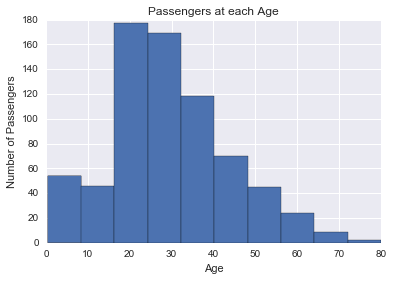

In [45]:
age_hist = titanic_df['Age'].hist()
age_hist.set_ylabel('Number of Passengers')
age_hist.set_xlabel('Age')
age_hist.set_title('Passengers at each Age')

Next is a boxplot depicting the age for passengers who survived and passengers who didn't (1 survived, 0 died). Survivors tended to be slightly younger.

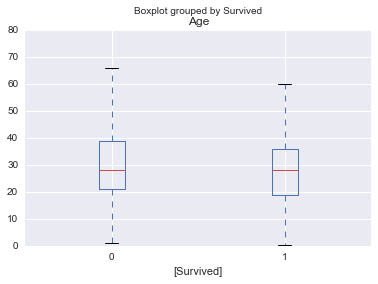

In [46]:
titanic_df.boxplot(column = ['Age'], by = ['Survived'])

### Descriptive Statistics Regarding Age and Survival

In [47]:
print 'Average Age\n', titanic_df.groupby('Survived')['Age'].mean()
print '\nMedian Age\n', titanic_df.groupby('Survived')['Age'].median()
print '\nStandard Deviation\n', titanic_df.groupby('Survived')['Age'].std()
print '\nMinimum Age\n', titanic_df.groupby('Survived')['Age'].min()
print '\nMaximum Age\n', titanic_df.groupby('Survived')['Age'].max()

Average Age
Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

Median Age
Survived
0    28.0
1    28.0
Name: Age, dtype: float64

Standard Deviation
Survived
0    14.172110
1    14.950952
Name: Age, dtype: float64

Minimum Age
Survived
0    1.00
1    0.42
Name: Age, dtype: float64

Maximum Age
Survived
0    74.0
1    80.0
Name: Age, dtype: float64


## How does economic class affect survival?

Our hypothesis is that those of lower economic class will have been less likely to survive. I would also like to explore the possibility that those for whom no age was recorded were on average of a lower class than those who's ages were recorded. Class will be represented both by Pclass and Fare. (In Pclass, lower numbers mean higher class, ie 1st class, 2nd class, 3rd class.)

### What is the likelihood of survival for each passenger class?

In [48]:
# Taking the mean here effectively reveals the likelihood of survival for members of each passenger class.
print titanic_df.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


We can see here that the results here completely fly in the face of my original suggestion that in a crisis situation economic class may have mattered less or that the positioning of upper class quarters may have compromised safety for luxury and by some strange twist of fate lower class quarters may have been better positioned to avoid drowning within the ship and to access lifeboats. Neither of these two suppositions appear to have played any factor at all as we can very clearly see that first class passengers were more likely to survive than second class passengers who were twice as likely to survive as third class passengers.

It helps to see these numbers in the context of the actual number of passengers in each group.

In [49]:
# Find out how many passengers were in each class.
count_pclass = titanic_df['Pclass'].value_counts()
print count_pclass

3    491
1    216
2    184
Name: Pclass, dtype: int64


In [50]:
# Re-order the count_pclass series so that the indexes are in the proper order
count_pclass.sort_index(inplace=True)
print count_pclass

1    216
2    184
3    491
Name: Pclass, dtype: int64


In [51]:
#Make sure the series containing the total survivors will also have properly ordered indices
titanic_df.groupby('Pclass')['Survived'].sum()

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64

### Visualizations

Here is a bar graph showing total passengers (yellow) and survivors (blue) in each class (1, 2, 3).

We can see here that despite there being over twice as many third class passengers as first class passengers, still more first class passengers survived than third class passengers.

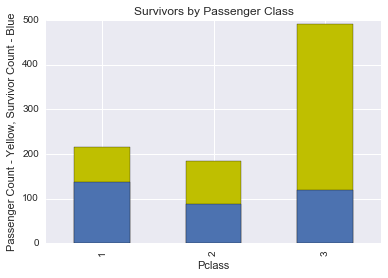

In [52]:
# Plot both the total passengers in each class against the total survivors from each class
count_pclass.plot(kind='bar', color='y',title='Survivors by Passenger Class').set_ylabel('Passenger Count - Yellow, Survivor Count - Blue')
titanic_df.groupby('Pclass')['Survived'].sum().plot(kind='bar')

Next is a histogram showing the distribution of passengers along what fare they paid.

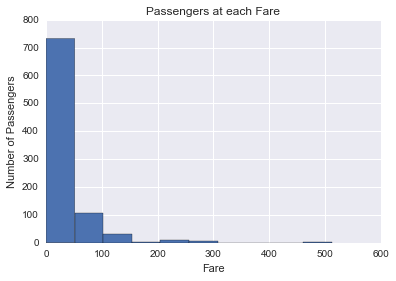

In [54]:
age_hist = titanic_df['Fare'].hist()
age_hist.set_ylabel('Number of Passengers')
age_hist.set_xlabel('Fare')
age_hist.set_title('Passengers at each Fare')

Below is a box plot of logarithmically adjusted fare paid by those who survived and by those who died. Those who survived had typically paid a higher fare.

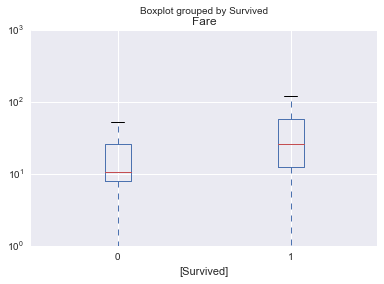

In [55]:
titanic_df.boxplot(column = ['Fare'], by = ['Survived']).set_yscale('log')

Below is a scatterplot comparing the age of passengers to the fare they paid. There are no obvious trends except that most of the higher fares were paid by passengers between 20 and 60.

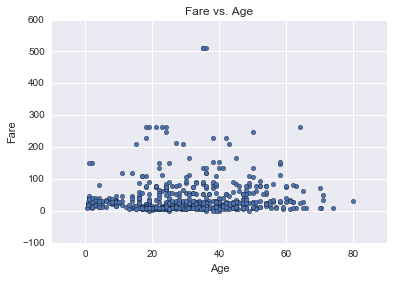

In [56]:
titanic_df.plot(kind = 'scatter', x = 'Age', y = 'Fare', title = 'Fare vs. Age')

The following boxplot compares logarithmically adjusted fare to passenger class. This reveals the obvious trend that first class tickets are the most expensive, then second class, then third class.

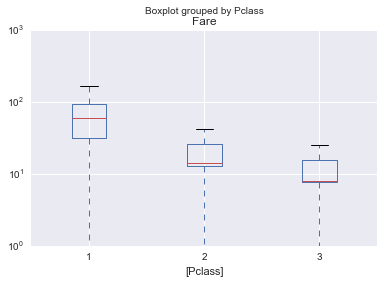

In [57]:
titanic_df.boxplot(column = ['Fare'], by = ['Pclass']).set_yscale('log')

### Descriptive Statistics Regarding Fare and Survival
Yet more evidence that those of a higher socioeconomic status were more likely to survive the ordeal aboard the Titanic. Both the mean, median and maximum fare of survivors were roughly twice those of casualties. 

In [58]:
print 'Average Fare\n', titanic_df.groupby('Survived')['Fare'].mean()
print '\nMedian Fare\n', titanic_df.groupby('Survived')['Fare'].median()
print '\nStandard Deviation\n', titanic_df.groupby('Survived')['Fare'].std()
print '\nMinimum Fare\n', titanic_df.groupby('Survived')['Fare'].min()
print '\nMaximum Fare\n', titanic_df.groupby('Survived')['Fare'].max()

Average Fare
Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

Median Fare
Survived
0    10.5
1    26.0
Name: Fare, dtype: float64

Standard Deviation
Survived
0    31.388207
1    66.596998
Name: Fare, dtype: float64

Minimum Fare
Survived
0    0.0
1    0.0
Name: Fare, dtype: float64

Maximum Fare
Survived
0    263.0000
1    512.3292
Name: Fare, dtype: float64


### The Question of the Ageless Passengers
Were passengers with no recorded age more likely to have been of lower class? First we must differentiate between those passengers who have an age and those who do not. We will do this with a new column.

In [59]:
#Create a new HasAge column
import math

def has_age(age):
    if math.isnan(age):
        return 'No Age'
    else:
        return 'Has Age'

titanic_df['HasAge'] = titanic_df['Age'].apply(has_age)

display(titanic_df.head())

,PassengerId,Survived,Pclass,Sex,Age,Fare,AgeGroup,HasAge
0,1,0,3,male,22.0,7.2500,5. Adult (19-60),Has Age
1,2,1,1,female,38.0,71.2833,5. Adult (19-60),Has Age
2,3,1,3,female,26.0,7.9250,5. Adult (19-60),Has Age
3,4,1,1,female,35.0,53.1000,5. Adult (19-60),Has Age
4,5,0,3,male,35.0,8.0500,5. Adult (19-60),Has Age


In [60]:
# We see below that there are as many passengers with No Age as there were passengers with No Age Reported in AgeGroup
# (177). This suggests that our new column works as we predicted.
print titanic_df['HasAge'].value_counts()

Has Age    714
No Age     177
Name: HasAge, dtype: int64


In [61]:
#Print the number of passengers in each class for each of the Has Age vs No Age groups
age_vs_pclass = titanic_df.groupby('HasAge')['Pclass'].value_counts()
print age_vs_pclass

HasAge   Pclass
Has Age  3         355
         1         186
         2         173
No Age   3         136
         1          30
         2          11
Name: Pclass, dtype: int64


In [62]:
# Find what percentage of each group Has Age vs No Age is made up of each class.
age_vs_pclass_ha = age_vs_pclass['Has Age']
age_vs_pclass_na = age_vs_pclass['No Age']

age_vs_pclass_ha.sort_index(inplace=True)
age_vs_pclass_na.sort_index(inplace=True)

print '\nHas Age\n', age_vs_pclass_ha.div(714)
print '\nNo Age\n', age_vs_pclass_na.div(177)


Has Age
Pclass
1    0.260504
2    0.242297
3    0.497199
Name: Pclass, dtype: float64

No Age
Pclass
1    0.169492
2    0.062147
3    0.768362
Name: Pclass, dtype: float64


The above code reveals that those without a recorded age were made up of 76% people from third class compared to 49% among those with a recorded age. Our hypothesis appears to have been correct.

### Visualizations

Here are two bar graphs, one for Has Age, the other for No Age showing total passengers in the group--No Age vs Has Age--(yellow) and total passengers (blue) in each class (1, 2, 3).

We can see here very clearly that among those without a recorded age, an overwhelming majority of them were third class.

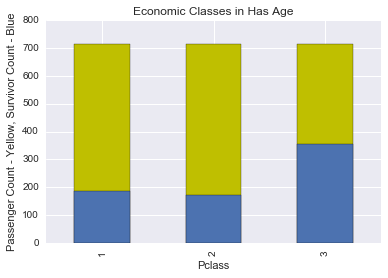

In [63]:
# Plot both the total members of Has Age and the total members of each class in Has Age
pd.Series([714,714,714]).plot(kind='bar', title='Economic Classes in Has Age', color='y').set_ylabel('Passenger Count - Yellow, Survivor Count - Blue')

age_vs_pclass_ha.plot(kind='bar')

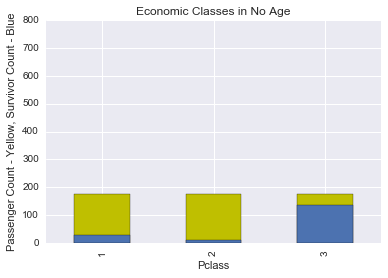

In [66]:
# Plot both the total members of No Age and the total members of each class in No Age
pd.Series([177,177,177]).plot(kind='bar', title='Economic Classes in No Age', ylim=(0,800), color='y').set_ylabel('Passenger Count - Yellow, Survivor Count - Blue')

age_vs_pclass_na.plot(kind='bar')

### Descriptive Statistics Regarding Fare and Recorded Age
Yet more evidence that those of a lower socioeconomic status were less likely to have had a recorded age. Both the mean, median and maximum fare of those with a recorded age were greater than those without a recorded age. 

In [29]:
print 'Average Fare\n', titanic_df.groupby('HasAge')['Fare'].mean()
print '\nMedian Fare\n', titanic_df.groupby('HasAge')['Fare'].median()
print '\nStandard Deviation\n', titanic_df.groupby('HasAge')['Fare'].std()
print '\nMinimum Fare\n', titanic_df.groupby('HasAge')['Fare'].min()
print '\nMaximum Fare\n', titanic_df.groupby('HasAge')['Fare'].max()

Average Fare
HasAge
Has Age    34.694514
No Age     22.158567
Name: Fare, dtype: float64

Median Fare
HasAge
Has Age    15.7417
No Age      8.0500
Name: Fare, dtype: float64

Standard Deviation
HasAge
Has Age    52.918930
No Age     31.874608
Name: Fare, dtype: float64

Minimum Fare
HasAge
Has Age    0.0
No Age     0.0
Name: Fare, dtype: float64

Maximum Fare
HasAge
Has Age    512.3292
No Age     227.5250
Name: Fare, dtype: float64


## Conclusions
At the beginning of the analysis, we asked three questions. Here are the answers we came up with
- How does gender affect passenger survival?
    - We discovered that women were more likely to survive the Titanic tragedy than men. In fact more than twice as many women survived as men despite there being more men aboard.
- How does age affect passenger survival?
    - We discovered that younger passengers, particularly infants, toddlers and children were more likely to survive the ordeal than adolescents, adults and seniors. We also discovered that despite this the average age for survivors was roughly 28 while the average age for casualties was roughly thirty (not much older). The medians were the same at 28. This suggests that among adults (the dominant group) age was less of a factor in survival.
- How does socioeconomic class affect passenger survival?
    - In terms of socioeconomic class we discovered that those in third class were much more likely to be casualties. Those of higher economic class were more likely to survive. In fact the fare paid by those who survived was on average double that of those who became casualties. We also noticed that among those who's ages were not known an overwhelming majority were of lower socioeconomic class.


The biggest shortcoming we came up against in determining what factors were most likely to determine survival was that a significant number of passengers had no recorded age. This made it more difficult to determine what impact age had on the survival of the passengers.